In [11]:
import librosa 
import librosa.display
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tensorflow import keras 
from tensorflow.keras.preprocessing import image_dataset_from_directory, image 

In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [33]:
path = Path.cwd()/'data'
answers = pd.read_csv(path/'train.csv')


In [35]:
answers['name'] = answers['clip_name'].str.split('.').str[0]
answers['clip_path']=path/'train'/answers['clip_name']
answers['image_path']=path/'train_images'/(answers['name']+'.jpg')
answers.head()

,clip_name,label,name,clip_path,image_path
0,train1.aiff,0,train1,/Users/mariapolyakova/Documents/metis/deep/rig...,/Users/mariapolyakova/Documents/metis/deep/rig...
1,train2.aiff,0,train2,/Users/mariapolyakova/Documents/metis/deep/rig...,/Users/mariapolyakova/Documents/metis/deep/rig...
2,train3.aiff,0,train3,/Users/mariapolyakova/Documents/metis/deep/rig...,/Users/mariapolyakova/Documents/metis/deep/rig...
3,train4.aiff,0,train4,/Users/mariapolyakova/Documents/metis/deep/rig...,/Users/mariapolyakova/Documents/metis/deep/rig...
4,train5.aiff,0,train5,/Users/mariapolyakova/Documents/metis/deep/rig...,/Users/mariapolyakova/Documents/metis/deep/rig...


<AxesSubplot:xlabel='label', ylabel='Count'>

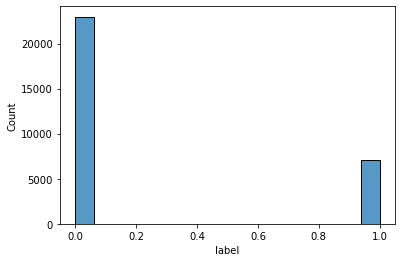

In [9]:
sns.histplot(data=answers, x='label')
# So we've got >20K no right whales, and 5K right whales examples. 

# Processing Sound Data
* Dont load the entire dataset into memory. There are 30K sound files in there - small ones, but still

* Load in 
* Turn into mel spectrogram
* Sampling rate is the same for everything - 2000
* Length is the same as well - 2 seconds (which we then stretch) 
* Since the sound is already cut into batches, and they all start pretty consistenly at the start, we don't need to time shift 

## Questions
Two major ones I can think of: 
* Do we want to resample? We can later, but lets start with no
* Should we mask frequencies? Since we're keeping it at the base 2000, we don't need to mask frequencies 

## How many files
* Lets start with 5 so my laptop doesnt die 



In [15]:
which_file = 6
filename1 = f'''train{which_file}.aiff'''
filename1
y, sr = librosa.load('data/train/'+filename1,sr=None)
# sr=2000

# y = librosa.resample(y0, orig_sr=sr0, target_sr=sr)
#Specifying the sampling rate explicitly, since this is given 
print(y.shape)
print(sr)

(4000,)
2000


In [57]:
def read_sound(index):
    row = answers.iloc[index]
    clip_path = row['clip_path']
    image_path = row['image_path']
    y, sr = librosa.load(clip_path, sr=None)
    del clip_path, row
    return y, sr, image_path 

def create_spectrogram(input_tuple):
    y, sr, output_file = input_tuple
    fig = plt.figure(figsize=[0.72, 0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    spec = librosa.feature.melspectrogram(y=y, sr=sr)
    librosa.display.specshow(librosa.power_to_db(spec, ref=np.max))
    plt.savefig(output_file, dpi=400, bbox_inches='tight', pad_inches=0)
    plt.close()
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del spec, fig, ax, y, sr, output_file, input_tuple
    
    

In [68]:
create_spectrogram(read_sound(5))

In [72]:
sample = pd.concat([answers[answers['label']==0].sample(3, random_state=1),answers[answers['label']==1].sample(3, random_state=1)])
sample.head(6)

,clip_name,label,name,clip_path,image_path
10239,train10240.aiff,0,train10240,/Users/mariapolyakova/Documents/metis/deep/rig...,/Users/mariapolyakova/Documents/metis/deep/rig...
9519,train9520.aiff,0,train9520,/Users/mariapolyakova/Documents/metis/deep/rig...,/Users/mariapolyakova/Documents/metis/deep/rig...
12749,train12750.aiff,0,train12750,/Users/mariapolyakova/Documents/metis/deep/rig...,/Users/mariapolyakova/Documents/metis/deep/rig...
29781,train29782.aiff,1,train29782,/Users/mariapolyakova/Documents/metis/deep/rig...,/Users/mariapolyakova/Documents/metis/deep/rig...
26564,train26565.aiff,1,train26565,/Users/mariapolyakova/Documents/metis/deep/rig...,/Users/mariapolyakova/Documents/metis/deep/rig...
25236,train25237.aiff,1,train25237,/Users/mariapolyakova/Documents/metis/deep/rig...,/Users/mariapolyakova/Documents/metis/deep/rig...


In [ ]:
% load_ext memory_profiles

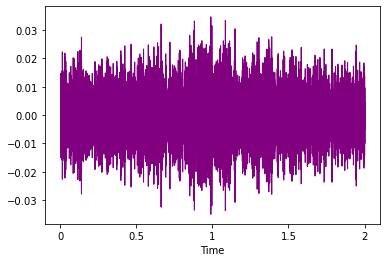

In [136]:
librosa.display.waveshow(y, sr=sr, x_axis='time',color='purple')
#Ok, pretty consistent sound throughout the sample
#Not huge spikes up or silence,and pretty even by the looks of it - with a slight spikiness inthe middle 
#Most of the papers I've looked at actually use the spectogram, and treat it like an image 


In [137]:
# #Lets see if we can look at some pitches?? 
# # https://librosa.org/doc/latest/_modules/librosa/core/pitch.html
# pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
# plt.plot(pitches)
# plt.show()


# pitches.shape #Yes, all frequencies about a certain level are cut- this is expected, because the true sample rate is low

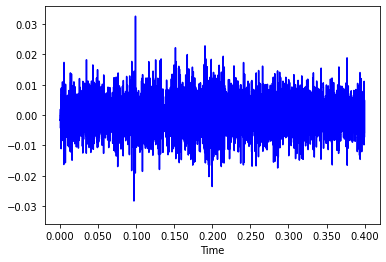

In [138]:
which_file = 8
filename1 = f'''train{which_file}.aiff'''
filename1
y2, sr2 = librosa.load('data/train/'+filename1, sr=None)
librosa.display.waveshow(y2, sr=sr, x_axis='time',color='blue')

In [139]:
# pitches, magnitudes = librosa.core.piptrack(y=y2, sr=sr)
# plt.plot(pitches)
# plt.show()
# #Well, Im not seeing much difference - not surprising, only human:) 

(129, 63)


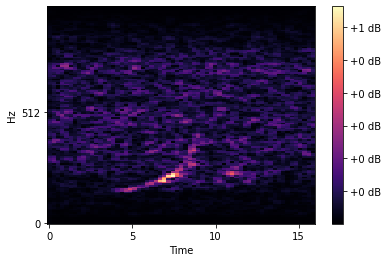

In [256]:
# mfccs = librosa.feature.mfcc(y=y, sr=sr)
n_fft=256

Y = librosa.stft(y, n_fft=n_fft)
#Window length explanation: https://dsp.stackexchange.com/questions/248/how-do-i-optimize-the-window-lengths-in-stft 
#Since we care about the frequency more than the time, we should keep the window default 
print(Y.shape)
librosa.display.specshow(Y,sr=sr,x_axis='time', y_axis='mel',n_fft=n_fft)
plt.colorbar(format='%+2.0f dB')
#So generally, Melgrams - closer to the way we hear, perform better. However, these are whales, after all, underwater - will it actually perform better?? Or is what works for humans not ideal in this case? 
#Cat classificator uses mel spectrograms 
# https://en.wikipedia.org/wiki/Whale_vocalization 
#Right whales dont quite sing - they do an "upcall"
#So - humans hear on the melscale. Maybe whales dont. But - in order to visualize better, I want to see the spectrogram better for humans
#Same with amplitude



In [239]:
Y.shape



(1025, 20)

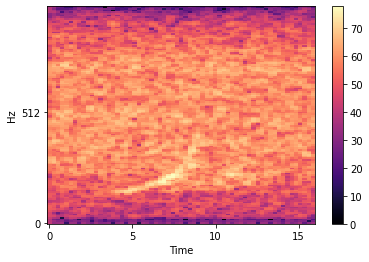

In [260]:
Y1, _ = librosa.magphase(Y ) #Use melscale instead of raw frequency 
Y2 = librosa.feature.melspectrogram(S=Y1,sr=sr,  n_fft=n_fft)
melgram = librosa.amplitude_to_db(Y2, ref=np.min) #Use the minimum of our array as zero: https://librosa.org/doc/main/generated/librosa.amplitude_to_db.html
librosa.display.specshow(melgram, sr=sr, x_axis='time', y_axis='mel', n_fft=n_fft)
plt.colorbar()

#Hm, not sure if better. We shall see?? 
#Lets try the DB correction but without melgram? 
# melgram = librosa.amplitude_to_db(Y, ref=np.min)
# librosa.display.specshow(melgram, sr=sr, x_axis='time', y_axis='mel')
# plt.colorbar()
#no, very bright almost everywhere, and the white hot patch in the middle is not as visible. 
#Back to mel





(array([[1.05565901e-10, 1.54192080e-10, 5.53210341e-11, ...,
         6.74199514e-11, 1.41598480e-10, 7.21222656e-11],
        [1.40417269e-10, 1.95187685e-10, 1.97316086e-12, ...,
         7.21072900e-11, 1.97602387e-10, 1.33032881e-11],
        [6.85360547e-11, 8.10744173e-11, 1.60903505e-11, ...,
         3.55391199e-11, 6.90146341e-11, 4.96015153e-11],
        ...,
        [9.67481665e-12, 9.48512263e-12, 9.21221291e-12, ...,
         2.78254666e-11, 1.45305791e-10, 6.95951234e-10],
        [1.80862766e-11, 9.62768242e-12, 2.53562764e-12, ...,
         2.24946567e-12, 6.80831837e-11, 1.26644265e-10],
        [1.43470655e-11, 1.17557486e-12, 1.18347599e-13, ...,
         4.70030479e-13, 1.61635012e-11, 2.37404895e-12]]),
 array([   0.    ,    7.8125,   15.625 ,   23.4375,   31.25  ,   39.0625,
          46.875 ,   54.6875,   62.5   ,   70.3125,   78.125 ,   85.9375,
          93.75  ,  101.5625,  109.375 ,  117.1875,  125.    ,  132.8125,
         140.625 ,  148.4375,  156.25  ,  1

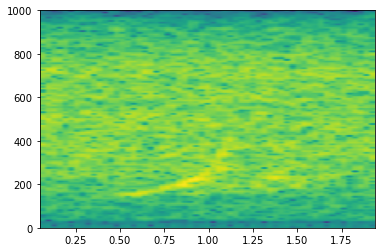

In [263]:
#Another way to do the spectrogram: 
params = {'NFFT':256, 'Fs':sr, 'noverlap':192}
plt.specgram(y, **params)
#Looks pretty similar to me

# Brief Discussion About Sample Rate and Frequency 
https://www.dataq.com/data-acquisition/general-education-tutorials/what-you-really-need-to-know-about-sample-rate.html 

Sample Rate will control what frequencies we can recreate - ours is about 2000 Hz, which means we can recreate about half of that range - so we have to cut it there
Anything else will be reproduced as noise in the dataset 

## Should I still use the default resampling in Librosa? 
Yes - https://librosa.org/blog/2019/07/17/resample-on-load/
We wont see any additional frequencies, but it doesnt hurt, and produces pretties pictures on the spectrograms 
We still sample 4000 times - we should get our 4000 entries. 

## Should I cut the possible frequencies in librosa, even though the sample rate is high? 
Probably 



## What about the Whales 
https://dosits.org/galleries/audio-gallery/marine-mammals/baleen-whales/north-atlantic-right-whale/ 

We will miss some calls, but most of the up calls happen under 1000Hz, so we should be ok 


In [114]:
librosa.fft_frequencies(y, sr=sr)

/var/folders/9k/83m77rxs5835tnj2rh39wf3h0000gn/T/ipykernel_44803/2838611481.py:1: FutureWarning: Pass sr=[ 0.00103223 -0.00014445 -0.00153478 ...  0.00045475  0.00034369
  0.00020632] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.fft_frequencies(y, sr=sr)


ValueError: operands could not be broadcast together with shapes (1025,) (44100,) 